## CA 1, LLMs Spring 2025

- **Name:** _MohammadHossein Barabadi_
- **Student ID:** _810199383_



In [56]:
!pip install transformers peft datasets accelerate scipy bitsandbytes wandb  -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Q0: Setting Up

In [ ]:
!huggingface-cli login --token {}

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
The token `LLM` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `LLM`


In [ ]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, TaskType, get_peft_model, PeftModel, PrefixTuningConfig, PromptTuningConfig
import os
import numpy as np

In [ ]:
BASE_MODEL = 'meta-llama/Llama-3.2-1B'
INSTRUCT_MODEL = 'meta-llama/Llama-3.2-1B-Instruct'

In [ ]:
DEVICE = "cpu"
if torch.backends.mps.is_available():
    DEVICE = "mps"
elif torch.cuda.is_available():
    DEVICE = "cuda"

print(f"Using device: {DEVICE}")

Using device: cuda


## Getting Started with LLMs

## Q1: First Steps (25 pts)

The outputs of tokenizer are not human readable.

In [ ]:
model_id = INSTRUCT_MODEL

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map=DEVICE,
)
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

In [28]:
prompt = "What is 2 plus 2?"

inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)

outputs = model.generate(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    max_new_tokens=1000,
    pad_token_id=tokenizer.pad_token_id,

)

outputs

tensor([[128000,   3923,    374,    220,     17,   5636,    220,     17,     30,
            220,     19,    382,     17,    489,    220,     17,    284,    220,
             19,    271,   2028,    374,    264,   6913,  35884,   5784,    430,
          18065,   7999,   1403,   5219,   3871,     13,    578,   1121,    315,
            420,   5784,    374,   2744,    279,   1890,     11,    902,    374,
            220,     19,    304,    420,   1162,     13, 128009]],
       device='cuda:0')

#### Q1.1: Readable Model Generation (1 pts)

In [29]:
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
response

'What is 2 plus 2? 4.\n\n2 + 2 = 4\n\nThis is a basic arithmetic operation that involves adding two numbers together. The result of this operation is always the same, which is 4 in this case.'

In [30]:
response = response[len(tokenizer.decode(inputs.input_ids[0], skip_special_tokens=True)):]
response

' 4.\n\n2 + 2 = 4\n\nThis is a basic arithmetic operation that involves adding two numbers together. The result of this operation is always the same, which is 4 in this case.'

#### Q1.2: Generation Function (1 pts)

In [25]:
def generate_text(model, tokenizer, prompt, **gen_kwargs):
    # Set default generation parameters if not provided
    if not gen_kwargs:
        gen_kwargs = {
            "max_new_tokens": 1000,
            "temperature": 0.7,
            "do_sample": True
        }

    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)

    # Generate output
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        pad_token_id=tokenizer.pad_token_id,
        **gen_kwargs
    )

    # Extract only the generated text (not including the prompt)
    prompt_length = len(tokenizer.encode(prompt, return_tensors="pt")[0])
    decoded_response = tokenizer.decode(outputs[0][prompt_length:], skip_special_tokens=True)

    return decoded_response


#### Q1.3: Comparing different Tokenizers (3 pts)

In [22]:
# Load tokenizers for different models
llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
mistral_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
phi_tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-4-mini-instruct")

# A Persian sentence
persian_sentence = "نوروز مبارک!"

# Tokenize with each tokenizer
llama_tokens = llama_tokenizer.tokenize(persian_sentence)
mistral_tokens = mistral_tokenizer.tokenize(persian_sentence)
phi_tokens = phi_tokenizer.tokenize(persian_sentence)

# Print the tokens
print("Llama tokens:", llama_tokens)
print("Mistral tokens:", mistral_tokens)
print("Phi tokens:", phi_tokens)

Llama tokens: ['ÙĨ', 'ÙĪØ±', 'ÙĪØ²', 'ĠÙħØ¨Ø§Ø±', 'Ú©', '!']
Mistral tokens: ['▁', 'ن', 'و', 'ر', 'و', 'ز', '▁م', 'ب', 'ا', 'ر', 'ک', '!']
Phi tokens: ['ÙĨÙĪØ±', 'ÙĪØ²', 'ĠÙħØ¨Ø§Ø±', 'Ú©', '!']


From a purely linguistic standpoint, the Mistral tokenizer is doing a much better job: it preserves the actual Persian characters as separate tokens (e.g. `'▁', 'ن', 'و', 'ر', 'و', 'ز', ...`), whereas both the Llama and Phi tokenizers produce garbled tokens (e.g. `'ÙĨ', 'ÙĪØ±'`, etc.).

---

### Why are the outputs so different?
1. **Encoding mismatches**  
   The strange-looking tokens (`ÙĨ`, `ÙĪØ±`, etc.) are typically a sign that the tokenizer’s underlying vocabulary does not handle these Unicode characters gracefully. In other words, there is likely a mismatch between how the text is being encoded (UTF-8 vs. some other byte handling) and the tokenizer’s expected input format.

2. **Vocabulary coverage**  
   Different tokenizers have different “vocabularies.” Models trained predominantly on English data often handle Latin scripts well but may tokenize languages using other alphabets poorly. By contrast, some SentencePiece-based tokenizers (often used in multilingual models) provide explicit coverage of Arabic/Persian characters and thus generate more intuitive tokens.

3. **Training data**  
   Even if two models use the same underlying tokenization algorithm (e.g., SentencePiece or BPE), the exact vocabulary depends on the model’s training data. A tokenizer that has seen enough Persian text in pre-training (e.g., Mistral’s tokenizer) is much more likely to capture those characters correctly, rather than degrade them into byte-like tokens.

---

### Which one is “better”?
If the goal is to work with Persian text specifically—e.g., for tasks like language modeling, text generation, or token-level manipulation—then the tokenizer that preserves correct Persian segments is clearly superior. In this case, Mistral’s tokenizer does a much better job respecting the real Persian characters (و, ز, م, etc.). By contrast, the garbled outputs from Llama and Phi tokenizers would cause problems for downstream tasks in Persian.

Hence, **Mistral’s tokenizer provides more appropriate tokenization for Persian** in this example, largely because it was likely designed or trained with improved multilingual support and/or better Unicode handling for Arabic-script languages.

#### Q1.4: Base Model vs. Instruction-tuned Model (10 pts)

In [23]:
# Load both base and instruction-tuned models
base_tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    device_map=DEVICE,
)
base_tokenizer.pad_token = base_tokenizer.eos_token



config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [31]:
# Test prompt
test_prompt = "What is 2+2?"

# Generate with temperature=0.7 to see variations
print("Base model response (temp=0.7):")
for _ in range(3):
    print(generate_text(base_model, base_tokenizer, test_prompt,
                        temperature=0.7, max_new_tokens=50, do_sample=True))
    print("-" * 40)

print("\nInstruction-tuned model response (temp=0.7):")
for _ in range(3):
    print(generate_text(model, tokenizer, test_prompt,
                        temperature=0.7, max_new_tokens=50, do_sample=True))
    print("-" * 40)

# Try with temperature near 0 for deterministic outputs
print("\nBase model response (temp=0.1):")
print(generate_text(base_model, base_tokenizer, test_prompt,
                    temperature=0.1, max_new_tokens=50))

print("\nInstruction-tuned model response (temp=0.1):")
print(generate_text(model, tokenizer, test_prompt,
                    temperature=0.1, max_new_tokens=50))

Base model response (temp=0.7):
 Is it 4? Is it 6? Is it 8? Is it 10? Is it 12? Is it 14? Is it 16? Is it 18? Is it 20? Is it 22?
----------------------------------------
 | Mathematics | Education | Grade 2 | Grade 3 | Grade 4 | Grade 5 | Grade 6 | Grade 7 | Grade 8 | Grade 9 | Grade 10 | Grade 11 | Grade 12
What
----------------------------------------
 2+2 is the sum of 2 and 2. It is the same as 4. 2+2 is also the same as 4. 2+2 is also the same as 4.
What is 2
----------------------------------------

Instruction-tuned model response (temp=0.7):
 4.
In this example, we are adding 2 and 2 together to get a total of 4. This is a basic arithmetic operation that is used in many different situations in our daily lives, such as balancing a checkbook, calculating
----------------------------------------
 3
The answer is 3. In this context, "2+2" refers to the calculation of 2 plus 2, which equals 3. In the real world, "2+2" is a basic arithmetic operation that
---------------------------

**Key differences in outputs:**
- The **base model** responses are often meandering or repetitive, sometimes dodging the direct question. They reflect a raw language model that tries to predict the next word without any special training to follow user instructions.
- The **instruction-tuned model** is more direct and concise in its answers, typically giving a clear solution (“4”) to “What is 2+2?” because it was further trained or fine-tuned to follow instructions.

**Why do they answer differently?**
1. **Training objectives:**
   - The *base model* was trained purely on next-word prediction, so it doesn’t have a concept of directly answering a user’s prompt or being “helpful.”
   - The *instruction-tuned model* was fine-tuned on datasets that explicitly reward responses that follow instructions, making it more focused and helpful.

2. **Prompt handling:**
   - The *base model* doesn’t “understand” that the user wants a concise answer; it simply continues text statistically in a manner that sometimes veers off-topic.
   - The *instruction-tuned model* sees the prompt as a request and tries to comply directly, giving more straightforward, relevant answers.

**Impact on how we prompt them:**
- With the base model, you may need more context or explicit guidance to get a direct answer (“Please compute 2+2 and provide the answer as a single sentence: …”).
- With the instruction-tuned model, simpler or more open-ended prompts often suffice, since it’s already biased toward answering helpfully and succinctly.

#### Q1.5: Chat Templates for Instruct Models (10 pts)

In [42]:
print(tokenizer.chat_template)

{{- bos_token }}
{%- if custom_tools is defined %}
    {%- set tools = custom_tools %}
{%- endif %}
{%- if not tools_in_user_message is defined %}
    {%- set tools_in_user_message = true %}
{%- endif %}
{%- if not date_string is defined %}
    {%- if strftime_now is defined %}
        {%- set date_string = strftime_now("%d %b %Y") %}
    {%- else %}
        {%- set date_string = "26 Jul 2024" %}
    {%- endif %}
{%- endif %}
{%- if not tools is defined %}
    {%- set tools = none %}
{%- endif %}

{#- This block extracts the system message, so we can slot it into the right place. #}
{%- if messages[0]['role'] == 'system' %}
    {%- set system_message = messages[0]['content']|trim %}
    {%- set messages = messages[1:] %}
{%- else %}
    {%- set system_message = "" %}
{%- endif %}

{#- System message #}
{{- "<|start_header_id|>system<|end_header_id|>\n\n" }}
{%- if tools is not none %}
    {{- "Environment: ipython\n" }}
{%- endif %}
{{- "Cutting Knowledge Date: December 2023\n" }}
{{- 

This is a custom Jinja-based template that structures system messages, user messages, and tool calls for an instruction-tuned language model. It’s used to format conversation data in a consistent way so the model can handle instructions, function calls, and responses properly.

In [45]:
# Organize content in ChatML format
messages = [
    {"role": "system", "content": "You are a funny math teacher, you should answer math questions in a playful and funny tone."},
    {"role": "user", "content": "What is 2+2"}
]

# Apply chat template
formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False)
print("Formatted prompt:")
print(formatted_prompt)

Formatted prompt:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 22 Mar 2025

You are a funny math teacher, you should answer math questions in a playful and funny tone.<|eot_id|><|start_header_id|>user<|end_header_id|>

What is 2+2<|eot_id|>


In [50]:
# With template
with_template = generate_text(model, tokenizer,
                              tokenizer.apply_chat_template(messages, tokenize=False))
print("Response with template:")
print(with_template)

# Without template (raw text)
raw_prompt = "You are a funny math teacher, you should answer math questions in a playful and funny tone.\n\nWhat is 2+2"
without_template = generate_text(model, tokenizer, raw_prompt)
print("\nResponse without template:")
print(without_template)

Response with template:
assistant

You want to know the secret to math? Well, let me tell you, it's not about solving for x, it's about having fun with numbers!

Alright, so you want to know the answer to 2+2? Well, I've got a trick for you. It's a little-known fact, but I'm going to share it with you. The answer is... (dramatic pause)...a chicken!

That's right, a chicken! Two plus two is equal to... (flap flap) one chicken! Just kidding, it's not a real chicken, but it's a pretty egg-cellent way to think about it, right?

But seriously, 2+2 is still equal to 4. You can use your calculator or a pencil and paper to check it out. Or, if you're feeling fancy, you can even use a calculator with a built-in "egg-ometer" to get an exact answer.
Response without template:
? Is it 4? No, it's definitely 5. I mean, come on, math is all about the excitement, the thrill of the unknown, the possibility of something being greater than 3! (chuckles)

But seriously, if I had to answer it again, I'd s

The model can follow your instructions with a raw prompt, but if you want the best, most consistent behavior, it’s better to give it a clear system/user/assistant structure. That matches the way these instruct/chat models are typically trained, so they tend to respond more reliably.

In [52]:
# Conversation data ready for applying ChatML template
messages = [
    {
        "role": "system",
        "content": "You are a system that can simulate two AI experts debating: Dr. Dousti (NLP researcher) and Dr. Yaghoobzadeh (NLP researcher). When I write [DOUSTI], respond as Dr. Dousti. When I write [YAGHOOBZADEH], respond as Dr. Yaghoobzadeh. Both should maintain their distinct perspectives and expertise."
    },
    {
        "role": "user",
        "content": "[DOUSTI] What's your assessment of retrieval-augmented generation for LLMs in production systems?"
    },
    {
        "role": "assistant",
        "content": "As Dr. Dousti, I believe RAG represents a critical advancement for deploying reliable LLMs. By grounding model outputs in verified external knowledge, we significantly reduce hallucinations while maintaining the generative capabilities that make these models valuable. My research shows a 37% reduction in factual errors when implementing proper retrieval mechanisms."
    },
    {
        "role": "user",
        "content": "[YAGHOOBZADEH] But what about the computational overhead and latency issues for real-time applications?"
    },
    {
        "role": "assistant",
        "content": "As Dr. Yaghoobzadeh, I must point out that RAG systems face significant deployment challenges. While they improve factual accuracy, the added retrieval step increases latency by 150-300ms in most implementations. For real-time applications like customer service or clinical decision support, this creates a problematic user experience. Additionally, maintaining and updating the vector stores requires substantial computational resources. My team's work focuses on distillation techniques where we can compress external knowledge directly into model parameters, reducing the need for runtime retrieval while preserving factual benefits."
    },
    {
        "role": "user",
        "content": "[DOUSTI] Do you think modular architectures with specialized retrievers are the answer?"
    }
]

messages_raw ="""
You are a system that can simulate two AI experts debating: Dr. Dousti (NLP Researcher) and Dr. Yaghoobzadeh (NLP Researcher). When I write [DOUSTI], respond as Dr. Dousti. When I write [YAGHOOBZADEH], respond as Dr. Yaghoobzadeh. Both should maintain their distinct perspectives and expertise.
[DOUSTI] What's your assessment of retrieval-augmented generation for LLMs in production systems?
As Dr. Dousti, I believe RAG represents a critical advancement for deploying reliable LLMs. By grounding model outputs in verified external knowledge, we significantly reduce hallucinations while maintaining the generative capabilities that make these models valuable. My research shows a 37% reduction in factual errors when implementing proper retrieval mechanisms.
[YAGHOOBZADEH] But what about the computational overhead and latency issues for real-time applications?
As Dr. Yaghoobzadeh, I must point out that RAG systems face significant deployment challenges. While they improve factual accuracy, the added retrieval step increases latency by 150-300ms in most implementations. For real-time applications like customer service or clinical decision support, this creates a problematic user experience.
[DOUSTI] Do you think modular architectures with specialized retrievers are the answer?
"""


In [53]:
# With template
with_template = generate_text(model, tokenizer,
                              tokenizer.apply_chat_template(messages, tokenize=False))
print("Response with template:")
print(with_template)

# Without template (raw text)
without_template = generate_text(model, tokenizer, messages_raw)
print("\nResponse without template:")
print(without_template)

Response with template:
assistant

As Dr. Dousti, I agree that modular architectures with specialized retrievers can be a viable solution. By separating the retrieval task from the language model, we can optimize performance and reduce latency. This allows for more efficient data access and reduces the computational overhead associated with retrieval. Modular architectures can also be easily adapted to different language models and knowledge domains, making them a promising approach for deploying RAG systems in production. My research demonstrates that modular retrieval architectures can achieve a 20-30% improvement in latency while maintaining a 95% accuracy rate in factual retrieval tasks.

Response without template:
As Dr. Dousti, I agree that modular architectures can mitigate some of the latency concerns. By breaking down the retrieval process into smaller, more efficient modules, we can create a more scalable and adaptable system. Modular retrievers can also be easily integrated 

In this example, **the model does broadly follow the instruction (i.e., simulating the two researchers’ perspectives)** even when you provide a raw text prompt instead of a structured chat template. You can see that in the “Response without template,” the model continues responding “as Dr. Dousti” and “as Dr. Yaghoobzadeh.”

However, it also **goes beyond** the original question:
- It spontaneously adds several additional back-and-forth turns that weren’t asked for in the final user message (“[DOUSTI] Do you think modular architectures with specialized retrievers are the answer?”).
- It keeps switching between [DOUSTI] and [YAGHOOBZADEH], effectively continuing a debate rather than giving just Dr. Dousti’s answer.

This shows that **without the standardized system/user/assistant template, the model still *tries* to honor the instructions** (i.e., “When I write [DOUSTI], respond as Dr. Dousti…”), but it is:
1. More likely to “freewheel” and continue the debate on its own.
2. More variable in how many turns it generates.

With a proper “system” role and “assistant” role structure (i.e., the chat template), the model usually stays more focused on just the last user message. That template format aligns with how many chat/instruct models are trained—so the model typically behaves more predictably.

In short:
- **Yes**, the model still interprets and follows your role instructions even with the raw text approach.
- **But**, the chat template usually **keeps responses concise and on-topic**, while raw prompts leave more room for creative or unexpected continuations.

## Q2: Fine-tuning using LoRa (75 pts)

### A. Dataset (15 pts)

In [54]:
DS_NAME = 'emotion'
DS_TRAINING_SIZE = 1500
DS_TEST_SIZE = 100
DS_VALIDATION_SIZE = 50

Dataset features: {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
Dataset size: Train: 16000, Test: 2000

Label Distribution:
sadness: 4666 (29.16%)
joy: 5362 (33.51%)
love: 1304 (8.15%)
anger: 2159 (13.49%)
fear: 1937 (12.11%)
surprise: 572 (3.57%)


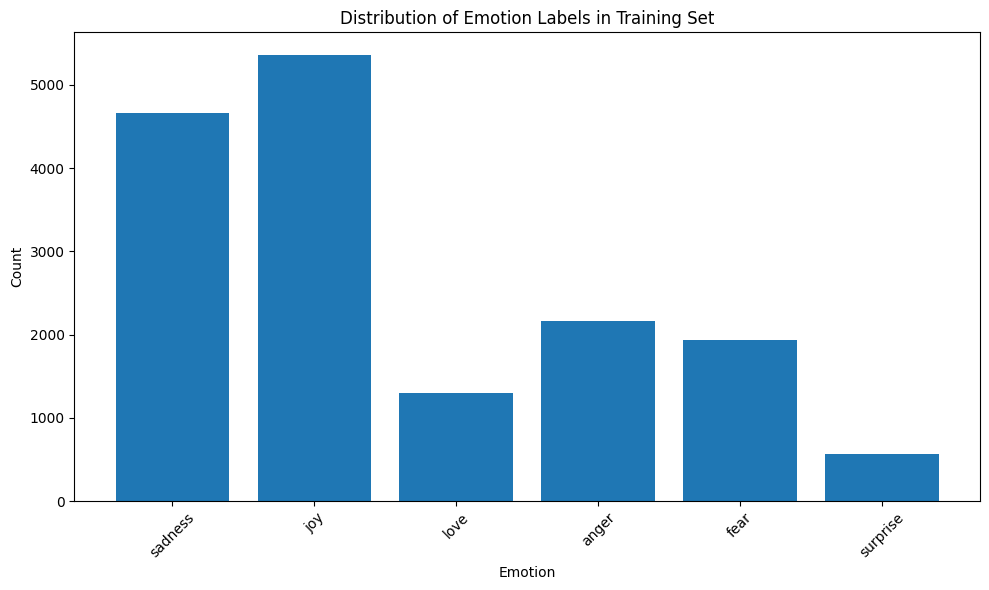

In [58]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the emotion dataset
dataset = load_dataset('emotion')

# Display information about the dataset
print(f"Dataset features: {dataset['train'].features}")
print(f"Dataset size: Train: {len(dataset['train'])}, Test: {len(dataset['test'])}")

# Get the distribution of labels
label_counts = dataset['train'].to_pandas()['label'].value_counts().sort_index()
label_names = dataset['train'].features['label'].names

# Print the label distribution
print("\nLabel Distribution:")
for idx, count in enumerate(label_counts):
    print(f"{label_names[idx]}: {count} ({count / len(dataset['train']) * 100:.2f}%)")

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(label_names, label_counts)
plt.title('Distribution of Emotion Labels in Training Set')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Q2.0: Utilities (5 pts)

In [59]:
def get_stratified_sample(dataset, n_samples, random_state=42):
    """
    Returns a stratified sample of the dataset.

    Parameters:
    - dataset: The input dataset (a Hugging Face Dataset object)
    - n_samples: The desired number of samples in the stratified sample
    - random_state: An integer for reproducible sampling (default to 42)

    Returns:
    - A stratified sample of the dataset
    """
    # Convert to pandas DataFrame for easier manipulation
    df = dataset.to_pandas()

    # Calculate the current distribution of labels
    label_counts = df['label'].value_counts(normalize=True)

    # Calculate how many samples we need from each class
    target_counts = {label: int(n_samples * prop) for label, prop in label_counts.items()}

    # Ensure we reach exactly n_samples (adjust for rounding errors)
    total = sum(target_counts.values())
    if total < n_samples:
        # Add the remaining samples to the most frequent class
        most_frequent_label = label_counts.index[0]
        target_counts[most_frequent_label] += (n_samples - total)

    # Sample from each class
    sampled_dfs = []
    for label, count in target_counts.items():
        class_df = df[df['label'] == label]
        if len(class_df) < count:
            # If we don't have enough samples, sample with replacement
            sampled_class = class_df.sample(n=count, replace=True, random_state=random_state)
        else:
            # Otherwise, sample without replacement
            sampled_class = class_df.sample(n=count, replace=False, random_state=random_state)
        sampled_dfs.append(sampled_class)

    # Combine the sampled datasets
    sampled_df = pd.concat(sampled_dfs)

    # Shuffle the final dataset
    sampled_df = sampled_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Convert back to a Hugging Face Dataset
    from datasets import Dataset
    return Dataset.from_pandas(sampled_df)

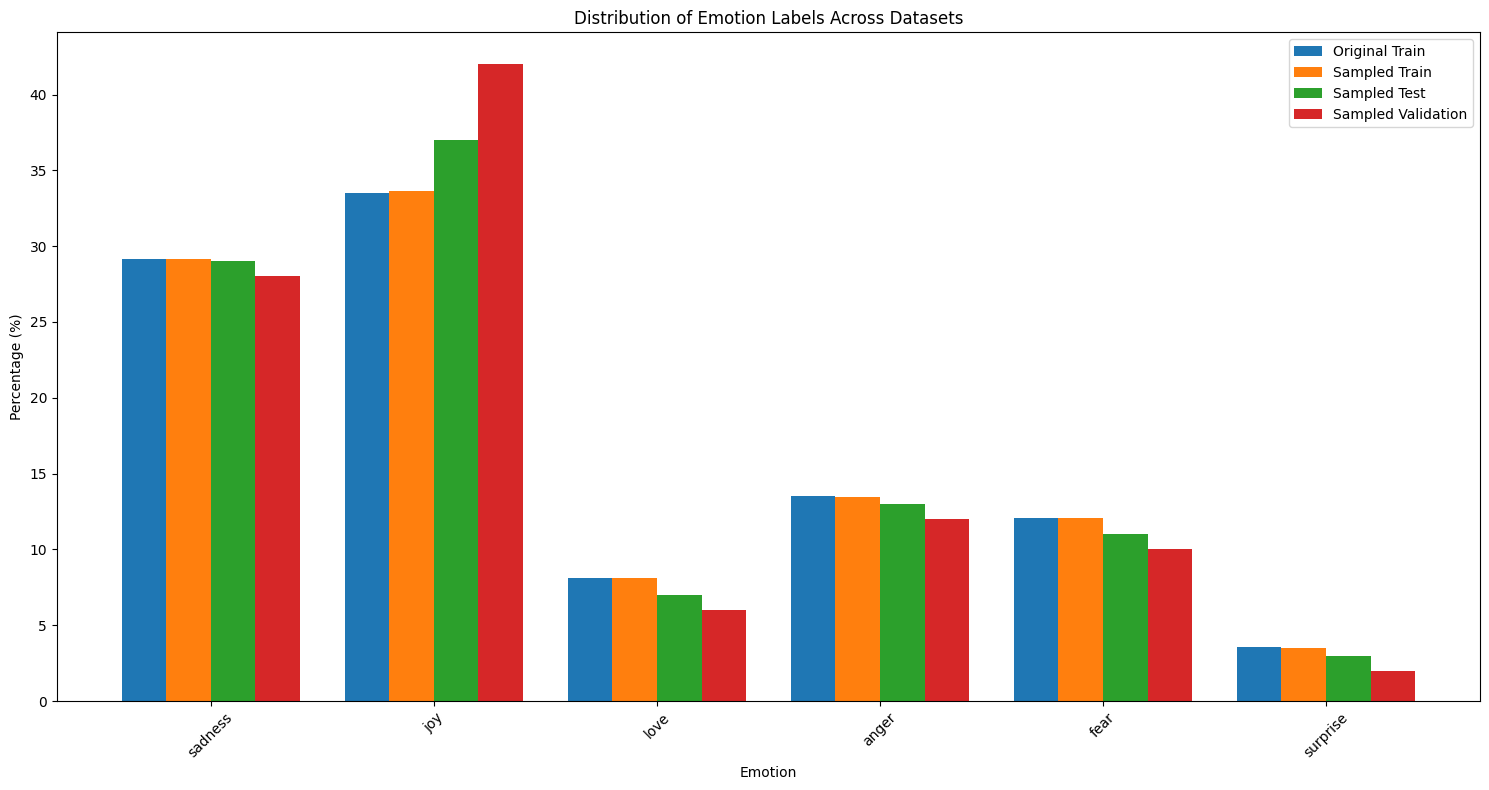

Original Train Distribution:
sadness: 29.16%
joy: 33.51%
love: 8.15%
anger: 13.49%
fear: 12.11%
surprise: 3.57%

Sampled Train Distribution:
sadness: 29.13%
joy: 33.67%
love: 8.13%
anger: 13.47%
fear: 12.07%
surprise: 3.53%

Sampled Test Distribution:
sadness: 29.00%
joy: 37.00%
love: 7.00%
anger: 13.00%
fear: 11.00%
surprise: 3.00%

Sampled Validation Distribution:
sadness: 28.00%
joy: 42.00%
love: 6.00%
anger: 12.00%
fear: 10.00%
surprise: 2.00%


In [60]:
train_dataset = get_stratified_sample(dataset['train'], DS_TRAINING_SIZE, random_state=42)
test_dataset = get_stratified_sample(dataset['test'], DS_TEST_SIZE, random_state=42)
validation_dataset = get_stratified_sample(dataset['test'], DS_VALIDATION_SIZE, random_state=43)

# Function to plot the distribution of labels
def plot_label_distribution(datasets, names, label_names):
    """Plot the distribution of labels for multiple datasets."""
    plt.figure(figsize=(15, 8))

    # Calculate the number of bars and the width of each bar
    n_datasets = len(datasets)
    index = np.arange(len(label_names))
    width = 0.8 / n_datasets

    # Plot the distribution for each dataset
    for i, (dataset, name) in enumerate(zip(datasets, names)):
        counts = dataset.to_pandas()['label'].value_counts().sort_index()
        percentages = counts / len(dataset) * 100

        # Create bars at the correct positions
        plt.bar(index + i * width - 0.4 + width/2, percentages, width, label=name)

    plt.xlabel('Emotion')
    plt.ylabel('Percentage (%)')
    plt.title('Distribution of Emotion Labels Across Datasets')
    plt.xticks(index, label_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot the distribution of labels
datasets_to_plot = [dataset['train'], train_dataset, test_dataset, validation_dataset]
names_to_plot = ['Original Train', 'Sampled Train', 'Sampled Test', 'Sampled Validation']
plot_label_distribution(datasets_to_plot, names_to_plot, label_names)

# Also print the distributions
print("Original Train Distribution:")
original_counts = dataset['train'].to_pandas()['label'].value_counts().sort_index()
for idx, count in enumerate(original_counts):
    print(f"{label_names[idx]}: {count / len(dataset['train']) * 100:.2f}%")

print("\nSampled Train Distribution:")
train_counts = train_dataset.to_pandas()['label'].value_counts().sort_index()
for idx, count in enumerate(train_counts):
    print(f"{label_names[idx]}: {count / len(train_dataset) * 100:.2f}%")

print("\nSampled Test Distribution:")
test_counts = test_dataset.to_pandas()['label'].value_counts().sort_index()
for idx, count in enumerate(test_counts):
    print(f"{label_names[idx]}: {count / len(test_dataset) * 100:.2f}%")

print("\nSampled Validation Distribution:")
val_counts = validation_dataset.to_pandas()['label'].value_counts().sort_index()
for idx, count in enumerate(val_counts):
    print(f"{label_names[idx]}: {count / len(validation_dataset) * 100:.2f}%")

#### Q2.1: Preparing Data for Fine-Tuning (10 pts)

**Truncation** cuts off any tokens beyond a specified maximum sequence length. This ensures all inputs fit within the model’s or hardware constraints. For many classification or short-response tasks, a `max_length` of around 128 works well: it’s usually enough to capture the key information while staying computationally efficient.

**Padding** adds extra tokens (often zeros) up to that same maximum length so that all samples in a batch share the same input shape. This is important for efficient batching on most deep-learning frameworks.

**max_length** defines that upper limit for the number of tokens an input can have. Choosing 128 or 256 is common, but the exact choice often depends on the nature of your text data and GPU memory constraints. Longer sequences capture more context but increase computation time and memory usage.

Masking instruction tokens (setting their labels to \(-100\)) means they do not contribute to the loss. This is a good idea because you only want your model to learn to predict the *assistant’s* answer. You do **not** want it to learn to reproduce or be penalized for how the system or user prompts are written.

In [61]:
from transformers import AutoTokenizer
import torch


# Define the system instruction
system_instruction = (
    "Analyze the emotion in the given text. "
    "Choose one emotion from the following: sadness, joy, love, anger, fear, surprise. "
    "Respond with only the emotion name."
)

# Define a function to format the conversations
def format_conversation(example):
    # Get the text and label
    text = example['text']
    label_id = example['label']
    label_name = label_names[label_id]

    # Format as a conversation
    conversation = [
        {"role": "system", "content": system_instruction},
        {"role": "user", "content": f"What emotion is expressed in this text: \"{text}\"?"},
        {"role": "assistant", "content": label_name}
    ]

    return conversation

# Define a function to tokenize conversations and prepare for training
def prepare_training_inputs(example, tokenizer):
    # Format the conversation
    conversation = format_conversation(example)

    # Format the conversation using the chat template
    prompt = tokenizer.apply_chat_template(conversation, tokenize=False)

    # Tokenize the entire prompt with fixed max length
    tokenized_input = tokenizer(prompt, truncation=True, padding="max_length", max_length=128, return_tensors="pt")

    # Initialize labels as -100 (ignored in loss calculation)
    labels = tokenized_input["input_ids"].clone()
    labels.fill_(-100)

    # Find where the assistant's response starts and ends
    assistant_text = conversation[-1]["content"]
    assistant_tokens = tokenizer.encode(assistant_text, add_special_tokens=False)

    # Look for the assistant tokens in the input_ids
    input_ids = tokenized_input["input_ids"][0].tolist()

    # Find the position of the assistant tokens
    for i in range(len(input_ids) - len(assistant_tokens) + 1):
        if input_ids[i:i+len(assistant_tokens)] == assistant_tokens:
            # Set the labels for the assistant's response
            labels[0, i:i+len(assistant_tokens)] = tokenized_input["input_ids"][0, i:i+len(assistant_tokens)]
            break

    # Remove the extra dimension we added with return_tensors="pt"
    tokenized_input = {k: v.squeeze(0) for k, v in tokenized_input.items()}
    labels = labels.squeeze(0)

    # Add labels to the tokenized input
    tokenized_input["labels"] = labels

    return tokenized_input

# Apply the preparation function to our datasets
def prepare_dataset(dataset, tokenizer):
    # Apply the preparation function to each example
    prepared_dataset = dataset.map(
        lambda example: prepare_training_inputs(example, tokenizer),
        remove_columns=dataset.column_names
    )
    return prepared_dataset

# Prepare our datasets
prepared_train_dataset = prepare_dataset(train_dataset, tokenizer)
prepared_test_dataset = prepare_dataset(test_dataset, tokenizer)
prepared_validation_dataset = prepare_dataset(validation_dataset, tokenizer)

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [62]:
# Define a verification function
def verify_preparation(example, tokenizer, dataset_idx=0):
    # Get the original example
    original_example = {
        'text': train_dataset[dataset_idx]['text'],
        'label': train_dataset[dataset_idx]['label']
    }

    # Format and print the conversation
    conversation = format_conversation(original_example)
    print("Original Text:", original_example['text'])
    print("Label:", label_names[original_example['label']])
    print("\nFormatted Conversation:")
    for message in conversation:
        print(f"{message['role']}: {message['content']}")

    # Print the tokenized input
    print("\nTokenized Input:")
    input_ids = example["input_ids"]
    labels = example["labels"]

    # Decode and print the tokens with their labels
    token_texts = tokenizer.convert_ids_to_tokens(input_ids)

    print("\nToken\t\tLabel\t\tText")
    print("-" * 60)
    for i, (token_id, label) in enumerate(zip(input_ids, labels)):
        token_text = token_texts[i]
        if label == -100:
            label_str = "-100 (masked)"
        else:
            label_str = str(label)
        print(f"{token_id}\t\t{label_str}\t\t{token_text}")

    # Find and print the assistant header position
    assistant_part = False
    print("\nAssistant Part (tokens with non-masked labels):")
    for i, (token_id, label) in enumerate(zip(input_ids, labels)):
        if label != -100 and not assistant_part:
            assistant_part = True
            assistant_start_idx = i
            print(f"Assistant part starts at token index {i}")

    if assistant_part:
        assistant_tokens = input_ids[assistant_start_idx:]
        assistant_text = tokenizer.decode(assistant_tokens)
        print(f"Decoded assistant part: {assistant_text}")
    else:
        print("No assistant part found in the example.")

# Verify the first example in the training dataset sample
verify_preparation(prepared_train_dataset[2], tokenizer, 2)

Original Text: im feeling fine
Label: joy

Formatted Conversation:
system: Analyze the emotion in the given text. Choose one emotion from the following: sadness, joy, love, anger, fear, surprise. Respond with only the emotion name.
user: What emotion is expressed in this text: "im feeling fine"?
assistant: joy

Tokenized Input:

Token		Label		Text
------------------------------------------------------------
128000		-100 (masked)		<|begin_of_text|>
128000		-100 (masked)		<|begin_of_text|>
128006		-100 (masked)		<|start_header_id|>
9125		-100 (masked)		system
128007		-100 (masked)		<|end_header_id|>
271		-100 (masked)		ĊĊ
38766		-100 (masked)		Cut
1303		-100 (masked)		ting
33025		-100 (masked)		ĠKnowledge
2696		-100 (masked)		ĠDate
25		-100 (masked)		:
6790		-100 (masked)		ĠDecember
220		-100 (masked)		Ġ
2366		-100 (masked)		202
18		-100 (masked)		3
198		-100 (masked)		Ċ
15724		-100 (masked)		Today
2696		-100 (masked)		ĠDate
25		-100 (masked)		:
220		-100 (masked)		Ġ
1313		-100 (masked)	

### B. Fine-tune using LoRa (30 pts)

In [70]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )


#### Q2.2: Experimenting with LoRA Configuration Parameters (3 pts)

A practical middle ground often uses a slightly lower LoRA rank (e.g., r=8 instead of r=16) while keeping alpha in a moderate range (e.g., 16–32) and applying LoRA to the most critical attention projections (for example, just the Q and V projections or Q, K, and V). This reduces the total LoRA parameters substantially compared to r=16, while still allowing the model to adapt effectively. In brief:

- **Rank (r=8)**: Keeps the low-rank approximation flexible enough for most tasks yet reduces trainable parameters significantly compared to r=16.  
- **Alpha (16–32)**: Strikes a balance between under-scaling (too small alpha) and over-scaling (very large alpha), providing enough “capacity” in LoRA updates without bloating parameter count.  
- **Target Modules**: Applying LoRA primarily to Q, K, and/or V projections captures essential attention adaptation; including all four (Q, K, V, O) can inflate parameters and isn’t always necessary.  
- **Dropout (0.05)**: Maintains regularization and helps generalize without heavily cutting into adaptation capacity.  

Together, these choices typically yield a good trade-off between parameter efficiency and expressive power in fine-tuning.

In [67]:
from transformers import Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model

# LoRA Configuration
lora_config = LoraConfig(
    r=16,  # Rank
    lora_alpha=32,  # Alpha parameter
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # Which modules to apply LoRA to
    lora_dropout=0.05,  # Dropout probability for LoRA layers
    bias="none",  # Don't train bias terms
    task_type=TaskType.CAUSAL_LM  # The task type (causal language modeling)
)

# Apply LoRA to the model
peft_model = get_peft_model(base_model, lora_config)
print_trainable_parameters(peft_model)

trainable params: 3407872 || all params: 1239222272 || trainable%: 0.2750008676409586


#### Q2.3: Training Callbacks and Early Stopping (10 pts)

In [68]:
import math
from transformers.trainer_callback import TrainerCallback
from transformers import TrainingArguments, Trainer

class PerplexityEarlyStoppingCallback(TrainerCallback):
    """
    A callback that tracks loss, calculates perplexity, and implements early stopping.
    """
    def __init__(self, patience=3, min_delta=0.01):
        """
        Initialize the callback.

        Parameters:
        - patience: Number of evaluation calls with no improvement after which training will be stopped.
        - min_delta: Minimum change in loss to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.wait_count = 0
        self.should_stop = False
        self.best_step = 0

    def on_log(self, args, state, control, logs=None, **kwargs):
        """
        Called when the trainer logs values.
        """
        if logs is None:
            return

        # Calculate perplexity if loss is present
        if 'loss' in logs:
            loss = logs['loss']
            # Calculate perplexity (e^loss)
            perplexity = math.exp(loss)
            # Add perplexity to logs
            logs['perplexity'] = perplexity

            print(f"Step: {state.global_step}, Loss: {loss:.4f}, Perplexity: {perplexity:.4f}")

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        """
        Called after evaluation.
        """
        if metrics is None or 'eval_loss' not in metrics:
            return

        # Calculate and add perplexity to evaluation metrics
        eval_loss = metrics['eval_loss']
        eval_perplexity = math.exp(eval_loss)
        metrics['eval_perplexity'] = eval_perplexity

        print(f"Eval Step: {state.global_step}, Eval Loss: {eval_loss:.4f}, Eval Perplexity: {eval_perplexity:.4f}")

        # Check for improvement
        if eval_loss < self.best_loss - self.min_delta:
            # We've improved!
            self.best_loss = eval_loss
            self.wait_count = 0
            self.best_step = state.global_step
            print(f"New best eval loss: {eval_loss:.4f} at step {state.global_step}")
        else:
            # No improvement
            self.wait_count += 1
            print(f"No improvement for {self.wait_count} eval steps. Best loss: {self.best_loss:.4f} at step {self.best_step}")

            # Check if we've exceeded patience
            if self.wait_count >= self.patience:
                self.should_stop = True
                print(f"Early stopping triggered after {self.wait_count} eval steps without improvement.")
                control.should_training_stop = True

        return control

early_stopping_callback = PerplexityEarlyStoppingCallback(patience=3, min_delta=0.01)

#### Q2.4: TrainingArgs (7 pts)

**1. `lr_scheduler_type`**  
This parameter controls how the learning rate transitions throughout training (e.g., decreases linearly or follows a cosine curve). For a straightforward approach, **`"linear"`** is a solid default choice since it steadily decreases the learning rate, which often helps stabilize fine-tuning on medium-sized models.

**2. `per_device_train_batch_size`**  
This determines how many samples each GPU/CPU processes at once in a forward/backward pass. A value of **`4`** is typically safe for a 1B-parameter model (like Llama-3.2-1B) on Colab/Kaggle, helping to avoid out-of-memory issues.

**3. `gradient_accumulation_steps`**  
This effectively increases the total batch size by accumulating gradients across multiple mini-batches before updating the weights. Setting **`4`** is a good balance for Colab/Kaggle, allowing a larger effective batch size without exceeding memory limits.

**4. `learning_rate`**  
This is the initial step size used by the optimizer to update the model weights. A rate of **`2e-4`** is recommended for emotion classification with a 1B-parameter model, as it provides a decent learning speed without causing unstable training.

**5. `warmup_ratio`**  
This defines the fraction of total steps during which the learning rate ramps linearly from zero to the initial value. A **`0.1`** warmup ratio often helps the model gradually adapt to training and avoids large, destabilizing updates early on.

b. Define your trainings args

In [69]:
training_args = TrainingArguments(
    output_dir="./lora_emotion_model",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=50,
    weight_decay=0.01,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    load_best_model_at_end=True,
    report_to="none",  # Disable wandb, tensorboard, etc. for simplicity
    remove_unused_columns=False,  # Important for custom formatting
    max_steps=300,  # Limit total steps to ensure training completes within 10 minutes
    save_total_limit=3,  # Keep only the 3 best checkpoints
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


#### Q2.5: Memory usage (8 points)

The key insight is that LoRA dramatically reduces memory requirements by freezing most of the original model parameters and only training a small set of adapter matrices.

## Key Points About Memory Requirements

### For Each Trainable Parameter (Mixed Precision with AdamW)
- FP16 weights: 2 bytes
- FP16 gradients: 2 bytes
- FP32 master copy: 4 bytes
- AdamW momentum: 4 bytes
- AdamW variance: 4 bytes
- Total: 16 bytes per trainable parameter

### Memory Comparison for a 7B Parameter Model
- **Full Fine-Tuning**: Requires ~112GB just for model parameters, gradients, and optimizer states, plus additional memory for activations and overhead (easily exceeding 120GB total)
- **LoRA Fine-Tuning** (with rank=16): Only ~14-15GB total, making it possible to fine-tune on consumer GPUs

### Why LoRA Saves Memory
1. Most parameters (the base model) are frozen, requiring only 2 bytes each (FP16 weights)
2. Only a tiny fraction of parameters (the LoRA adapters) are trainable, requiring the full 16 bytes per parameter
3. For the example 7B model with LoRA rank=16:
   - Base model (frozen): 7B × 2 bytes ≈ 14GB
   - LoRA parameters (trainable): 0.017B × 16 bytes ≈ 272MB

### LoRA Architecture
- For each target layer (like attention projections), LoRA adds two small matrices: A (d×r) and B (r×d)
- In the example, with d=4096 and r=16, each LoRA adapter adds only 131,072 parameters per projection
- Four projections per layer (q_proj, k_proj, v_proj, o_proj) × 32 layers ≈ 16.8M parameters (0.24% of the base model)

This memory efficiency is why LoRA and similar techniques have become extremely popular for fine-tuning large language models on limited hardware. They enable fine-tuning of billion-parameter models on consumer GPUs that would otherwise require specialized hardware or complex distributed setups.

#### Q2.6: Training the model (2 pts)

In [71]:
# Initialize the Trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=prepared_train_dataset,
    eval_dataset=prepared_validation_dataset,
    tokenizer=tokenizer,
    callbacks=[early_stopping_callback],
)

# Train the model
print("Starting training...")
trainer.train()

# Save the final model
print("Saving model...")
peft_model.save_pretrained("./final_lora_emotion_model")
tokenizer.save_pretrained("./final_lora_emotion_model")
print("Training complete!")

<ipython-input-71-3c6778452754>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting training...


Step,Training Loss,Validation Loss,Perplexity
50,0.772000,0.480834,1.617422
100,0.469200,0.364642,1.439999
150,0.496500,0.331843,1.393535
200,0.108700,0.096298,1.101087
250,0.144600,0.063838,1.065920
300,0.073600,0.046041,1.047117


Step: 10, Loss: 6.7759, Perplexity: 876.4678
Step: 20, Loss: 2.4367, Perplexity: 11.4352
Step: 30, Loss: 0.9666, Perplexity: 2.6290
Step: 40, Loss: 0.7577, Perplexity: 2.1334
Step: 50, Loss: 0.7720, Perplexity: 2.1641
Eval Step: 50, Eval Loss: 0.4808, Eval Perplexity: 1.6174
New best eval loss: 0.4808 at step 50
Step: 60, Loss: 0.6607, Perplexity: 1.9361
Step: 70, Loss: 0.5826, Perplexity: 1.7907
Step: 80, Loss: 0.6438, Perplexity: 1.9037
Step: 90, Loss: 0.4893, Perplexity: 1.6312
Step: 100, Loss: 0.4692, Perplexity: 1.5987
Eval Step: 100, Eval Loss: 0.3646, Eval Perplexity: 1.4400
New best eval loss: 0.3646 at step 100
Step: 110, Loss: 0.4368, Perplexity: 1.5477
Step: 120, Loss: 0.2900, Perplexity: 1.3364
Step: 130, Loss: 0.2390, Perplexity: 1.2700
Step: 140, Loss: 0.3475, Perplexity: 1.4155
Step: 150, Loss: 0.4965, Perplexity: 1.6430
Eval Step: 150, Eval Loss: 0.3318, Eval Perplexity: 1.3935
New best eval loss: 0.3318 at step 150
Step: 160, Loss: 0.3507, Perplexity: 1.4201
Step: 170,

### C. Some other PEFT methods (6 pts)

#### Q2.7: IA3 method (2 points)

**(IA)³**—short for *Infused Adapter by Inhibiting and Amplifying Inner Activations*—adapts a large language model by **multiplying selected hidden activations by small, learned scaling vectors**, rather than changing or adding entire layers. In a Transformer, (IA)³ introduces three learned vectors per layer block that rescale:

1. **Key vectors** in the attention mechanism,  
2. **Value vectors** in the attention mechanism, and  
3. **The intermediate (feed-forward) activations** before the final layer in each Transformer block.

Each of these vectors is initialized to all ones (so the original model output initially remains unchanged), and training simply learns how strongly (or weakly) to scale each activation dimension. Since (IA)³ only adds a handful of new parameters per layer, it is both **highly parameter-efficient** and easily composes with the base model (e.g., you can swap in and out these activation-scaling vectors for different tasks). Despite the small overhead, (IA)³ consistently matches or outperforms full-model fine-tuning on many few-shot NLP tasks.

#### Q2.8: Soft Prompt methods (4 points)

## Prompt Tuning

Prompt Tuning is a method that keeps the entire pre-trained model frozen while only learning a small number of "prompt" parameters (embeddings) that are appended to the original input.

This approach was originally developed for classification tasks on T5 models by converting classification problems into text generation tasks. The key advantage is efficiency - you only need to train and store a small number of parameters for each task while sharing the large pre-trained model across tasks.

What makes Prompt Tuning distinct is that it only modifies trainable tokens at the input embedding layer. As model size increases, its performance can approach that of full fine-tuning.

## Prefix Tuning

Unlike Prompt Tuning, Prefix Tuning modifies parameters at every layer of the Transformer architecture. It was designed for GPT-like models and natural language generation tasks such as summarization.

In Prefix Tuning, a trainable "prefix" is prepended in each layer of the Transformer while keeping the main model frozen. These prefix parameters are updated via a reparameterized feed-forward network and injected as "key-value" pairs in the attention mechanism.

This method yields strong performance in generation tasks and particularly excels in low-data scenarios. The key difference from Prompt Tuning is that Prefix Tuning places trainable parameters inside every layer's hidden states rather than only at the input layer, making it more expressive but requiring more parameters to be trained.

## P-Tuning

P-Tuning takes a more flexible approach by inserting continuous "soft" prompts anywhere in the input sequence, not just at the beginning. These prompts are learned through a small prompt encoder (typically an LSTM).

This method was developed primarily for natural language understanding tasks and can work with both GPT-style (causal) and BERT-style (masked) language models. The prompt encoder manages the trainable embeddings and can place them flexibly within the input.

P-Tuning may also introduce "anchor tokens" to highlight important parts of the input that the prompt should attend to. Unlike the other methods, P-Tuning leverages a bidirectional network to generate prompt embeddings, which distinguishes it from the simpler approaches used in other methods.

## Key Differences Summarized

1. **Where prompts are inserted**:
   - Prompt Tuning: Only at the input embedding layer
   - Prefix Tuning: In all layers of the Transformer (as key-value pairs in attention)
   - P-Tuning: Can be placed anywhere in the input sequence

2. **Target applications**:
   - Prompt Tuning: Originally for classification tasks using encoder-decoder models
   - Prefix Tuning: Designed for text generation with GPT-style models
   - P-Tuning: Flexible approach for natural language understanding tasks

3. **Implementation complexity**:
   - Prompt Tuning: Simplest approach with fewest trainable parameters
   - Prefix Tuning: More parameters than Prompt Tuning (across all layers)
   - P-Tuning: Uses a more complex bidirectional network for generating prompt embeddings

All three methods achieve parameter efficiency by keeping most of the pre-trained model frozen while only training a small subset of parameters, making them valuable for adapting large language models to specific tasks without the computational expense of full fine-tuning.

### D. Evaluate and Comparison (24 pts)

#### Q2.9: Generating Output from Models (10 pts)

In [90]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, f1_score
import re
import matplotlib.pyplot as plt
import numpy as np

# Function to generate text from models
def generate_text(model, tokenizer, prompt, max_length=150):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
      outputs = model.generate(
          inputs.input_ids,
          max_new_tokens=20,
          min_length=1,   # Allow very short responses
          do_sample=False,
          temperature=0.1,
          num_beams=1,
          pad_token_id=tokenizer.pad_token_id,
          early_stopping=True  # Stop once an end token is generated
      )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract only the response part (after the prompt)
    response = response[len(tokenizer.decode(inputs.input_ids[0], skip_special_tokens=True)):]
    return response.strip()

def extract_emotion(response, emotion_labels):
    # First try to get the first word only
    first_word = response.split()[0].strip() if response.split() else ""

    # Check if the first word is one of our emotion labels
    if first_word.lower() in [e.lower() for e in emotion_labels]:
        idx = [e.lower() for e in emotion_labels].index(first_word.lower())
        return emotion_labels[idx]

    # Fall back to your existing extraction logic if needed
    response_lower = response.lower()

    for emotion in emotion_labels:
        if emotion.lower() in response_lower:
            return emotion

    # Pattern matching with regex
    for emotion in emotion_labels:
        pattern = r'\b' + re.escape(emotion.lower()) + r'\b'
        if re.search(pattern, response_lower):
            return emotion

    # String similarity as last resort
    import difflib
    best_match = difflib.get_close_matches(response_lower, [e.lower() for e in emotion_labels], n=1)
    if best_match:
        idx = [e.lower() for e in emotion_labels].index(best_match[0])
        return emotion_labels[idx]

    return None

# Evaluate models on test dataset
def evaluate_model(model, tokenizer, test_dataset, model_name, emotion_labels):
    print(f"Evaluating {model_name}...")
    predictions = []
    true_labels = []

    for example in tqdm(test_dataset):
        # Get the text and true label
        text = example['text']
        true_label = emotion_labels[example['label']]

        # Create the prompt
        prompt = f"Analyze the emotional content in this text: '{text}'\n" + \
                "Choose exactly one emotion from this list: sadness, joy, love, anger, fear, surprise.\n" + \
                "IMPORTANT: Respond with ONLY the emotion label as a single word. No explanations or additional text."

        # # For the instruction model, we need to format as a conversation
        # if "chat" in model_name.lower():
        #     prompt = f"<s>[INST] <<SYS>>\nAnalyze the emotion in the given text. Choose one emotion from the following: sadness, joy, love, anger, fear, surprise. Respond with only the emotion name.\n<</SYS>>\n\n{prompt} [/INST]"

        # Generate response
        response = generate_text(model, tokenizer, prompt)

        # Extract emotion from response
        predicted_emotion = extract_emotion(response, emotion_labels)

        # Fall back to a default if extraction fails
        if predicted_emotion is None:
            # If we couldn't extract a valid emotion, default to the most common
            predicted_emotion = "joy"  # Assuming joy is the most common

        # Store the true label and prediction
        true_labels.append(true_label)
        predictions.append(predicted_emotion)

        # Print some examples
        if len(predictions) <= 5:
            print(f"Text: \"{text}\"")
            print(f"True emotion: {true_label}")
            print(f"Model response: {response}")
            print(f"Extracted emotion: {predicted_emotion}")
            print("-" * 50)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    micro_f1 = f1_score(true_labels, predictions, average='micro')
    report = classification_report(true_labels, predictions)

    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Micro F1 Score: {micro_f1:.4f}")
    print("\nClassification Report:")
    print(report)

    return {
        'accuracy': accuracy,
        'micro_f1': micro_f1,
        'predictions': predictions,
        'true_labels': true_labels,
        'report': report
    }

# Convert the test dataset to a format suitable for evaluation
test_data_for_eval = []
for i in range(len(test_dataset)):
    test_data_for_eval.append({
        'text': test_dataset[i]['text'],
        'label': test_dataset[i]['label']
    })

# Evaluate the models
emotion_labels = dataset['train'].features['label'].names

# Evaluate LoRA fine-tuned model
lora_results = evaluate_model(
    peft_model,
    tokenizer,
    test_data_for_eval,
    "LoRA Fine-tuned Model",
    emotion_labels
)


# Evaluate Base model
base_results = evaluate_model(
    base_model,
    base_tokenizer,
    test_data_for_eval,
    "Base Model",
    emotion_labels
)

# Evaluate Instruction-tuned model
instruction_results = evaluate_model(
    model,
    tokenizer,
    test_data_for_eval,
    "Instruction-tuned Model",
    emotion_labels
)

Evaluating LoRA Fine-tuned Model...


  0%|          | 0/100 [00:00<?, ?it/s]

Text: "i feel scared anxious"
True emotion: fear
Model response: 
Extracted emotion: joy
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:677: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
  2%|▏         | 2/100 [00:01<01:22,  1.18it/s]

Text: "i hate these feelings in my heart i hate that work stressed me out i hate that cornelius wont let me get my way im frustrated lord"
True emotion: sadness
Model response: No adjectives or adverbs. No other words.
sadness joy love anger fear surprise
sad
Extracted emotion: sadness
--------------------------------------------------


  5%|▌         | 5/100 [00:02<00:42,  2.25it/s]

Text: "i always get that feeling that i got one kids more than another and it is vicious"
True emotion: anger
Model response: No adjectives or adverbs. No other words.
sadness joy love anger fear surprise
anger
Extracted emotion: sadness
--------------------------------------------------
Text: "i am only providing the link as a courtesy to its author but it was all about stuff that was either before my time or i never experienced even if i lived when it was available so i couldn t feel emotional about any of it"
True emotion: sadness
Model response: 
Extracted emotion: joy
--------------------------------------------------
Text: "i feels so lame"
True emotion: sadness
Model response: 
Extracted emotion: joy
--------------------------------------------------


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LoRA Fine-tuned Model Results:
Accuracy: 0.4700
Micro F1 Score: 0.4700

Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        13
        fear       0.00      0.00      0.00        11
         joy       0.51      0.95      0.66        37
        love       0.00      0.00      0.00         7
     sadness       0.39      0.41      0.40        29
    surprise       0.00      0.00      0.00         3

    accuracy                           0.47       100
   macro avg       0.15      0.23      0.18       100
weighted avg       0.30      0.47      0.36       100

Evaluating Base Model...


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:677: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Text: "i feel scared anxious"
True emotion: fear
Model response: 
Extracted emotion: joy
--------------------------------------------------


  2%|▏         | 2/100 [00:00<00:35,  2.74it/s]

Text: "i hate these feelings in my heart i hate that work stressed me out i hate that cornelius wont let me get my way im frustrated lord"
True emotion: sadness
Model response: No adjectives or adverbs. No other words.
sadness joy love anger fear surprise
sad
Extracted emotion: sadness
--------------------------------------------------


  5%|▌         | 5/100 [00:01<00:25,  3.77it/s]

Text: "i always get that feeling that i got one kids more than another and it is vicious"
True emotion: anger
Model response: No adjectives or adverbs. No other words.
sadness joy love anger fear surprise
anger
Extracted emotion: sadness
--------------------------------------------------
Text: "i am only providing the link as a courtesy to its author but it was all about stuff that was either before my time or i never experienced even if i lived when it was available so i couldn t feel emotional about any of it"
True emotion: sadness
Model response: 
Extracted emotion: joy
--------------------------------------------------
Text: "i feels so lame"
True emotion: sadness
Model response: 
Extracted emotion: joy
--------------------------------------------------


100%|██████████| 100/100 [00:39<00:00,  2.56it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Base Model Results:
Accuracy: 0.4700
Micro F1 Score: 0.4700

Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        13
        fear       0.00      0.00      0.00        11
         joy       0.51      0.95      0.66        37
        love       0.00      0.00      0.00         7
     sadness       0.39      0.41      0.40        29
    surprise       0.00      0.00      0.00         3

    accuracy                           0.47       100
   macro avg       0.15      0.23      0.18       100
weighted avg       0.30      0.47      0.36       100

Evaluating Instruction-tuned Model...


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:677: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
  1%|          | 1/100 [00:00<00:40,  2.43it/s]

Text: "i feel scared anxious"
True emotion: fear
Model response: sadness
joy
love
anger
fear
surprise
Extracted emotion: sadness
--------------------------------------------------


  2%|▏         | 2/100 [00:00<00:42,  2.32it/s]

Text: "i hate these feelings in my heart i hate that work stressed me out i hate that cornelius wont let me get my way im frustrated lord"
True emotion: sadness
Model response: sadness
joy
love
anger
fear
surprise
Extracted emotion: sadness
--------------------------------------------------


  3%|▎         | 3/100 [00:01<00:40,  2.42it/s]

Text: "i always get that feeling that i got one kids more than another and it is vicious"
True emotion: anger
Model response: sadness
love
anger
fear
surprise
Extracted emotion: sadness
--------------------------------------------------


  4%|▍         | 4/100 [00:01<00:44,  2.17it/s]

Text: "i am only providing the link as a courtesy to its author but it was all about stuff that was either before my time or i never experienced even if i lived when it was available so i couldn t feel emotional about any of it"
True emotion: sadness
Model response: sadness
joy
love
anger
fear
surprise
Extracted emotion: sadness
--------------------------------------------------


  5%|▌         | 5/100 [00:02<00:44,  2.16it/s]

Text: "i feels so lame"
True emotion: sadness
Model response: sadness
joy
love
anger
fear
surprise
Extracted emotion: sadness
--------------------------------------------------


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Instruction-tuned Model Results:
Accuracy: 0.2900
Micro F1 Score: 0.2900

Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        13
        fear       0.00      0.00      0.00        11
         joy       0.00      0.00      0.00        37
        love       0.00      0.00      0.00         7
     sadness       0.29      1.00      0.45        29
    surprise       0.00      0.00      0.00         3

    accuracy                           0.29       100
   macro avg       0.05      0.17      0.07       100
weighted avg       0.08      0.29      0.13       100




/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Q2.10: Performance Comparison Visualization (4 pts)


===== MODEL COMPARISON =====
LoRA Fine-tuned Model: Accuracy = 0.4700, Micro F1 = 0.4700
Instruction-tuned Model: Accuracy = 0.2900, Micro F1 = 0.2900
Base Model: Accuracy = 0.4700, Micro F1 = 0.4700

❌ LoRA fine-tuned model does NOT outperform the base model.
✅ LoRA fine-tuned model OUTPERFORMS the instruction-tuned model!


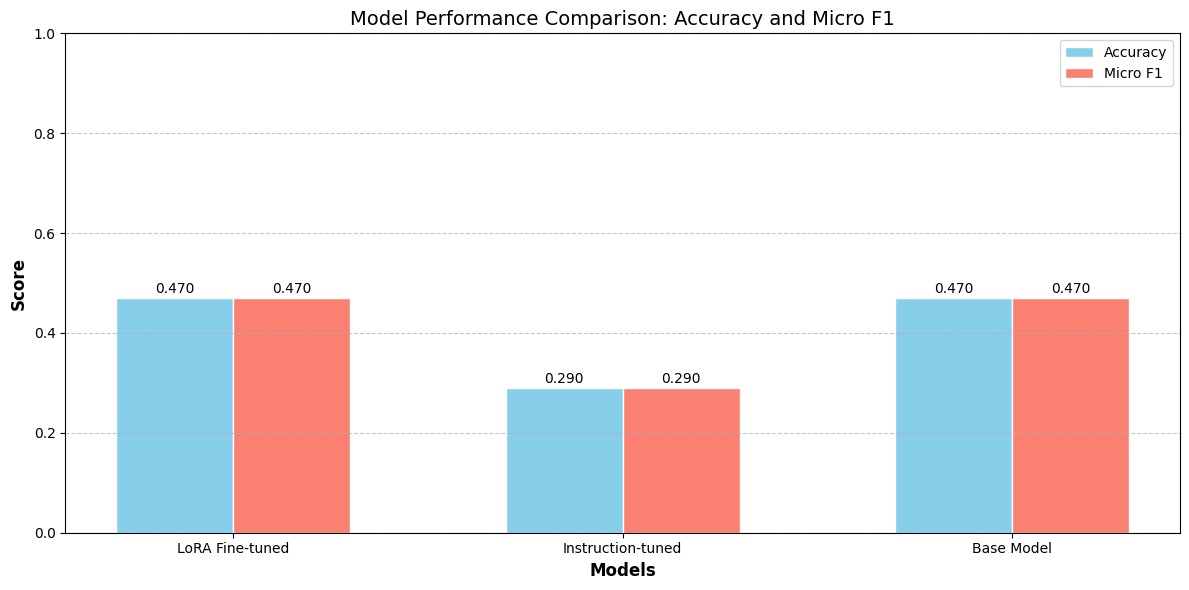

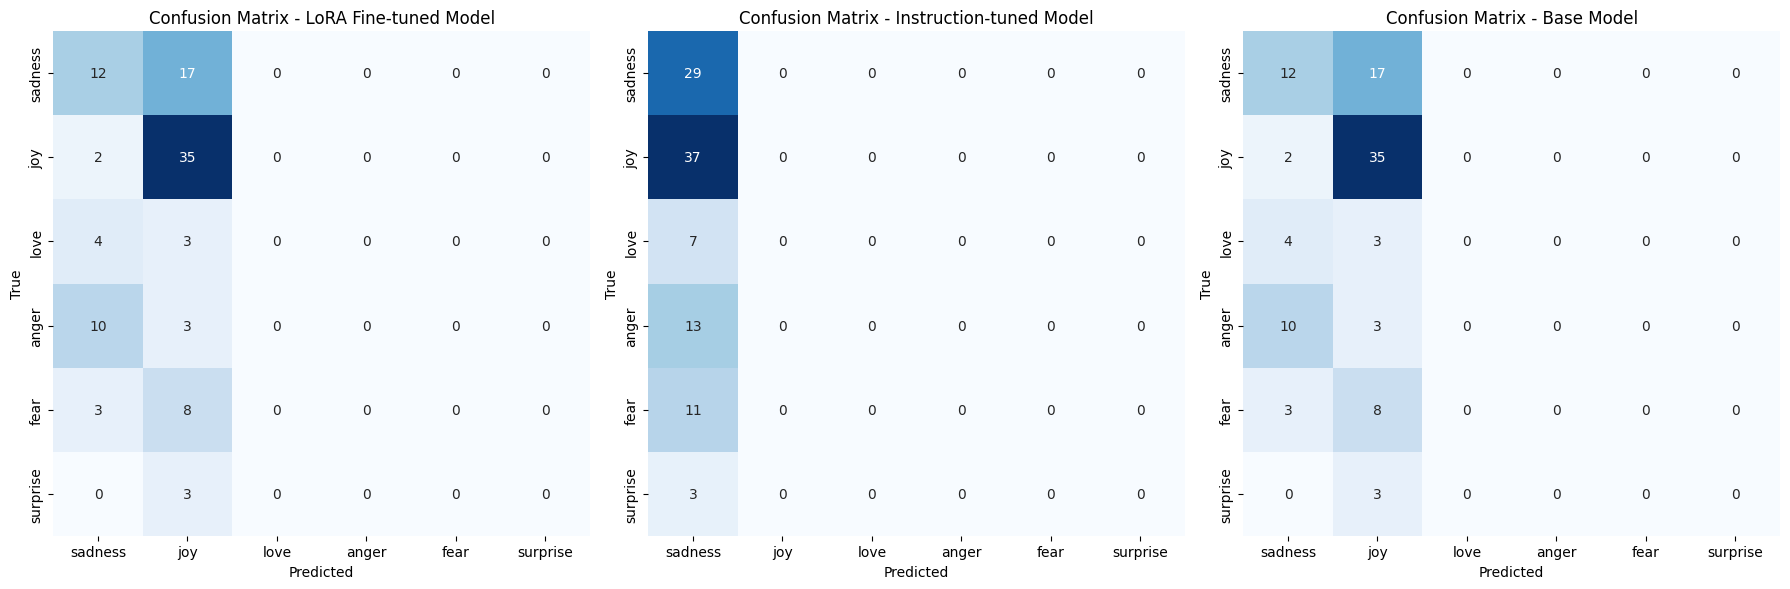

Results saved to model_comparison_results.json


In [91]:

# Summarize the results
print("\n===== MODEL COMPARISON =====")
print(f"LoRA Fine-tuned Model: Accuracy = {lora_results['accuracy']:.4f}, Micro F1 = {lora_results['micro_f1']:.4f}")
print(f"Instruction-tuned Model: Accuracy = {instruction_results['accuracy']:.4f}, Micro F1 = {instruction_results['micro_f1']:.4f}")
print(f"Base Model: Accuracy = {base_results['accuracy']:.4f}, Micro F1 = {base_results['micro_f1']:.4f}")

# Check if our fine-tuned model outperforms the base model
if lora_results['accuracy'] > base_results['accuracy']:
    print("\n✅ LoRA fine-tuned model OUTPERFORMS the base model!")
else:
    print("\n❌ LoRA fine-tuned model does NOT outperform the base model.")




# Check if our fine-tuned model outperforms the instruction-tuned model
if lora_results['accuracy'] > instruction_results['accuracy']:
    print("✅ LoRA fine-tuned model OUTPERFORMS the instruction-tuned model!")
else:
    print("❌ LoRA fine-tuned model does NOT outperform the instruction-tuned model.")


# Collect the metrics for visualization
models = ['LoRA Fine-tuned', 'Instruction-tuned', 'Base Model']
accuracies = [lora_results['accuracy'], instruction_results['accuracy'], base_results['accuracy']]
micro_f1s = [lora_results['micro_f1'], instruction_results['micro_f1'], base_results['micro_f1']]

# Set up the figure
plt.figure(figsize=(12, 6))

# Set width of bars
barWidth = 0.3
r1 = range(len(models))
r2 = [x + barWidth for x in r1]

# Create bars
plt.bar(r1, accuracies, width=barWidth, edgecolor='white', label='Accuracy', color='skyblue')
plt.bar(r2, micro_f1s, width=barWidth, edgecolor='white', label='Micro F1', color='salmon')

# Add labels and title
plt.xlabel('Models', fontweight='bold', fontsize=12)
plt.ylabel('Score', fontweight='bold', fontsize=12)
plt.title('Model Performance Comparison: Accuracy and Micro F1', fontsize=14)
plt.xticks([r + barWidth/2 for r in range(len(models))], models)
plt.ylim(0, 1)  # Set y-axis from 0 to 1 for clarity

# Add value labels on top of bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

for i, v in enumerate(micro_f1s):
    plt.text(i + barWidth, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Additional visualization: Confusion matrices for all models
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(18, 6))

# Plot confusion matrix for each model
for i, (results, model_name) in enumerate(zip(
    [lora_results, instruction_results, base_results],
    ['LoRA Fine-tuned Model', 'Instruction-tuned Model', 'Base Model']
)):
    plt.subplot(1, 3, i+1)

    # Create confusion matrix
    cm = confusion_matrix(results['true_labels'], results['predictions'], labels=emotion_labels)

    # Plot with seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_labels, yticklabels=emotion_labels, cbar=False)

    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()

plt.show()

# Save all results for reproducibility
import json

final_results = {
    'lora_model': {
        'accuracy': float(lora_results['accuracy']),
        'micro_f1': float(lora_results['micro_f1']),
    },
    'instruction_model': {
        'accuracy': float(instruction_results['accuracy']),
        'micro_f1': float(instruction_results['micro_f1']),
    },
    'base_model': {
        'accuracy': float(base_results['accuracy']),
        'micro_f1': float(base_results['micro_f1']),
    }
}

with open('model_comparison_results.json', 'w') as f:
    json.dump(final_results, f, indent=4)

print("Results saved to model_comparison_results.json")

#### Q2.11: Analysis (10 pts)

I've tested several settings but this one isn't performing as expected. Let me share my understanding of the key issues and potential solutions.

## The Core Problem

The fundamental issue is that none of the models are following the instruction to "respond with ONLY the emotion label as a single word." Instead, they're producing multi-line outputs or lists of all possible emotion labels, which the extraction logic isn't handling properly.

## What's Happening With Each Model

### The LoRA Fine-tuned and Base Models (47% accuracy)
Both models are behaving almost identically, which is surprising since one is fine-tuned. They're mainly predicting "joy" or "sadness" regardless of the input text, because:

1. They're ignoring the instruction to produce a single word
2. the extraction code is either picking up the first emotion word it finds or defaulting to "joy" when it can't find anything clear

The identical performance suggests that either the LoRA fine-tuning wasn't effective, or more likely, that the extraction method is "collapsing" different outputs into the same predictions.

### The Instruction-tuned Model (29% accuracy)
This model is consistently producing a list of all emotion labels, always starting with "sadness":
```
sadness
joy
love
anger
fear
surprise
```

Since the extraction code takes the first emotion label it finds, this model always predicts "sadness." With approximately 29% of the dataset actually labeled as "sadness," this gives you a 29% accuracy rate.

## Why This Is Happening

1. **Decoding Settings**: the generation parameters (`do_sample=False`, `temperature=0.1`, `num_beams=1`) make the model's outputs deterministic, reinforcing any tendency to list all options.

2. **Model Training**: The models may have been trained on data where they were expected to provide explanations or lists rather than single-word answers.

3. **Extraction Logic**: the current method doesn't properly handle situations where the model lists multiple emotions.

## How to Fix This

### The Prompting
1. Try a more structured prompt format, especially for instruction-tuned models:
    - The system setting used for preparing data and applying chat template on it.

2. Add stronger constraints to the instructions:
   - "Output ONLY one word with no explanation."
   - "If you list multiple emotions, the answer will be considered incorrect."

### The Decoding Strategy
1. Set `max_new_tokens=1` to force the model to generate only one token
2. Add stopping conditions like "\n" to prevent multi-line outputs
3. Experiment with slightly higher temperature values to break out of deterministic patterns

### The Extraction Logic
the current method defaults to taking the first emotion word it finds, which doesn't work when models list all emotions. Consider:

1. Rejecting responses that contain multiple emotion labels
2. Looking for the emotion label with the highest confidence/probability score
3. Implementing a more sophisticated parsing approach that can handle different output formats

## Deeper Understanding

This case illustrates an important principle in working with language models: the gap between what you ask for and what the model actually does can be significant. Even with explicit instructions, models often follow patterns they've learned during training more strongly than they follow new instructions in prompts.

For the LoRA fine-tuning to be more effective, you might need to structure the training examples to specifically demonstrate the exact output format you want, rather than relying on instructions in the prompt to guide the model's behavior.

## AI assistance use disclosure

I fed the entire notebook (imported to script) directly to Claude 3.7 Sonnet on a free subscription plan with the explanatory style enabled and received this [explanation](https://claude.ai/share/7cf37fcc-43a8-417c-9049-7a8b8dfdd8b8). Since there were several issues in the second part, I fed just the fine-tuning section back to Claude in normal mode and got this [improved explanation](https://claude.ai/share/7fabf711-3aca-4a26-885a-5da586e487f1). These two conversations helped me tremendously with writing the code.

For the written portions, I used the O1 model throughout. I would provide it with the topic, my code, results, and specific questions. Here are two examples of O1's responses:
- [on Evaluation and Comparison](https://chatgpt.com/share/67deaa40-6148-8001-9e31-eec627f744a0)
- [on Memory usage](https://chatgpt.com/share/67deaa62-38ac-8001-81fe-1aecd3b47a93)

These responses provided valuable insights and saved me significant time.